In [109]:
import torch
from torch import nn
from torchvision import transforms, models, datasets
from PIL import Image
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [110]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [111]:
training_set_dir = "/Learn_pytorch/Computer_Vision_with_PyTorch/Cat_and_dog/training_set/training_set"
test_set_dir = "/Learn_pytorch/Computer_Vision_with_PyTorch/Cat_and_dog/test_set/test_set"

In [112]:
import random
import cv2
import os

In [113]:
class Cat_Dog(Dataset):
    def __init__(self,
                 folder: str):
        cats = glob(pathname=folder + "/cats/*.jpg")
        dogs = glob(pathname=folder + "/dogs/*.jpg")
        self.fpaths = cats + dogs
        random.shuffle(x=self.fpaths)
        self.targets = [fpath.split('/')[-1].startswith("dog") for fpath in self.fpaths] # dog = 1, cat = 0
        
    def __len__(self): return len(self.fpaths)
    def __getitem__(self, index):
        f = self.fpaths[index]
        target = self.targets[index]
        im = cv2.imread(f)[:, :, ::-1]
        im = cv2.resize(src=im, dsize=(224, 224))
        return torch.tensor(im/225).permute(2, 0, 1).to(device=device).float(), torch.tensor([target]).float().to(device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])

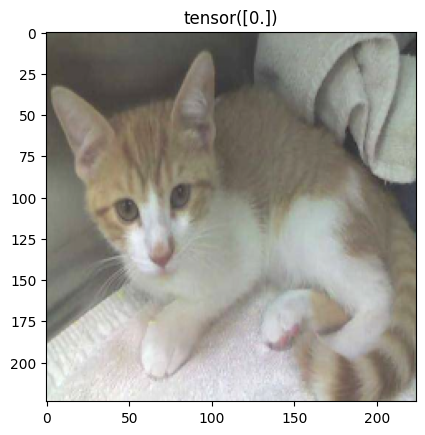

In [114]:
data = Cat_Dog(folder=training_set_dir)
img, label = random.choice(data)
plt.imshow(img.permute(1, 2, 0))
plt.title(label)
img.shape

In [115]:
def conv_layer(input_shape: int,
               output_shape: int,
               kernel_size: int,
               stride: int = 1):
    return nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=output_shape,
                  kernel_size=kernel_size,
                  stride=stride),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=output_shape),
        nn.MaxPool2d(kernel_size=2)
    )

In [116]:
class CNN_model(nn.Module):
    def __init__(self,
                 input_shape: int,
                 output_shape: int):
        super().__init__()
        self.conv_block = nn.Sequential(
            conv_layer(input_shape=input_shape, output_shape=64, kernel_size=3),
            conv_layer(input_shape=64, output_shape=512, kernel_size=3),
            conv_layer(input_shape=512, output_shape=512, kernel_size=3),
            conv_layer(input_shape=512, output_shape=512, kernel_size=3),
            conv_layer(input_shape=512, output_shape=512, kernel_size=3),
            conv_layer(input_shape=512, output_shape=512, kernel_size=3)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=512*1*1,
                      out_features=output_shape),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.classifier(self.conv_block(x))

In [117]:
model = CNN_model(input_shape=3,
                  output_shape=1)

In [118]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.001)

In [119]:
from torchsummary import summary
summary(model=model, input_data=(3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 1, 1]           --
|    └─Sequential: 2-1                   [-1, 64, 111, 111]        --
|    |    └─Conv2d: 3-1                  [-1, 64, 222, 222]        1,792
|    |    └─ReLU: 3-2                    [-1, 64, 222, 222]        --
|    |    └─BatchNorm2d: 3-3             [-1, 64, 222, 222]        128
|    |    └─MaxPool2d: 3-4               [-1, 64, 111, 111]        --
|    └─Sequential: 2-2                   [-1, 512, 54, 54]         --
|    |    └─Conv2d: 3-5                  [-1, 512, 109, 109]       295,424
|    |    └─ReLU: 3-6                    [-1, 512, 109, 109]       --
|    |    └─BatchNorm2d: 3-7             [-1, 512, 109, 109]       1,024
|    |    └─MaxPool2d: 3-8               [-1, 512, 54, 54]         --
|    └─Sequential: 2-3                   [-1, 512, 26, 26]         --
|    |    └─Conv2d: 3-9                  [-1, 512, 52, 52]         2,359,

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 1, 1]           --
|    └─Sequential: 2-1                   [-1, 64, 111, 111]        --
|    |    └─Conv2d: 3-1                  [-1, 64, 222, 222]        1,792
|    |    └─ReLU: 3-2                    [-1, 64, 222, 222]        --
|    |    └─BatchNorm2d: 3-3             [-1, 64, 222, 222]        128
|    |    └─MaxPool2d: 3-4               [-1, 64, 111, 111]        --
|    └─Sequential: 2-2                   [-1, 512, 54, 54]         --
|    |    └─Conv2d: 3-5                  [-1, 512, 109, 109]       295,424
|    |    └─ReLU: 3-6                    [-1, 512, 109, 109]       --
|    |    └─BatchNorm2d: 3-7             [-1, 512, 109, 109]       1,024
|    |    └─MaxPool2d: 3-8               [-1, 512, 54, 54]         --
|    └─Sequential: 2-3                   [-1, 512, 26, 26]         --
|    |    └─Conv2d: 3-9                  [-1, 512, 52, 52]         2,359,

In [120]:
def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_pred, y_true).sum().item()
    return (correct/len(y_pred))*100

In [121]:
if torch.cuda.is_available():
    model.cuda()

In [122]:
def train_step(train_dataloader: DataLoader,
               model: nn.Module,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = "cpu"):
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        model.train()
        y_hat = model(X)
        loss = loss_fn(y_hat, y)
        acc = accuracy_fn(y_pred=torch.round(y_hat), y_true=y)
        train_loss += loss
        train_acc += acc
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        model.eval()
        if batch < 100:
            if batch % 10 == 0:
                print(f"Look at batch {batch}")
        else:
            if batch % 100 == 0:
                print(f"Look at batch {batch}")
    
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    print(f"Train loss: {train_loss}        |       Train acc: {train_acc}")

In [123]:
def test_step(test_dataloader: DataLoader,
              model: nn.Module,
              loss_fn: nn.Module,
              accuracy_fn,
              device: torch.device = "cpu"):
    model.eval()
    with torch.inference_mode():
        test_loss, test_acc = 0, 0
        for batch, (X, y) in enumerate(test_dataloader):
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            loss = loss_fn(y_hat, y)
            test_loss += loss
            acc = accuracy_fn(y_pred=torch.round(y_hat), y_true=y)
            test_acc += acc
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        print(f"Test loss: {test_loss}      |       Test acc: {test_acc}")

In [124]:
train = Cat_Dog(training_set_dir)
train_dataloader = DataLoader(dataset=train, batch_size=32, shuffle=True, drop_last=True)
test = Cat_Dog(test_set_dir)
test_dataloader = DataLoader(dataset=test, batch_size=32, shuffle=True, drop_last=True)

In [125]:
from tqdm.auto import tqdm

In [126]:
epochs = 5
for epoch in tqdm(range(epochs)):
    train_step(train_dataloader=train_dataloader,
               model=model,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Look at batch 0
Look at batch 10
Look at batch 20
Look at batch 30
Look at batch 40
Look at batch 50
Look at batch 60
Look at batch 70
Look at batch 80
Look at batch 90
Look at batch 100
Look at batch 200


 20%|██        | 1/5 [45:44<3:02:59, 2744.87s/it]

Train loss: 0.6765487790107727        |       Train acc: 64.8125
Look at batch 0
Look at batch 10
Look at batch 20
Look at batch 30
Look at batch 40
Look at batch 50
Look at batch 60
Look at batch 70
Look at batch 80
Look at batch 90
Look at batch 100
Look at batch 200


 40%|████      | 2/5 [1:33:05<2:20:03, 2801.15s/it]

Train loss: 0.5481125712394714        |       Train acc: 71.55
Look at batch 0
Look at batch 10
Look at batch 20
Look at batch 30
Look at batch 40
Look at batch 50
Look at batch 60
Look at batch 70
Look at batch 80
Look at batch 90
Look at batch 100
Look at batch 200


 60%|██████    | 3/5 [2:20:03<1:33:37, 2808.89s/it]

Train loss: 0.45722800493240356        |       Train acc: 78.2125
Look at batch 0
Look at batch 10
Look at batch 20
Look at batch 30
Look at batch 40
Look at batch 50
Look at batch 60
Look at batch 70
Look at batch 80
Look at batch 90
Look at batch 100
